<a href="https://colab.research.google.com/github/alecbidaran/Object-segmentation-for-automonous-vehicles/blob/main/pytorch_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2 

In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [ ]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (112,112))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (112,112))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to("cuda")
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to("cuda")
        return ims, ce_masks

In [ ]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

(112, 112, 3)
(112, 112)
(112, 112, 3)


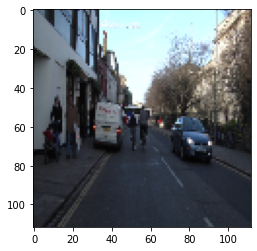

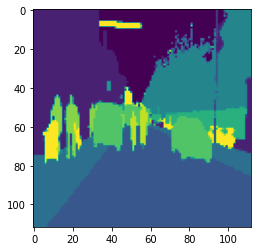

In [ ]:
image,mask=trn_ds[0]
print(image.shape)
print(mask.shape)
plt.imshow(image)
plt.figure()
plt.imshow(mask)
print(image.shape)

In [ ]:
image,label=next(iter(trn_dl))
label.shape

torch.Size([4, 224, 224])

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
import torch.nn.functional as F

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [ ]:
vgg16_bn(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
model = UNet().to("cuda")
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

RuntimeError: ignored

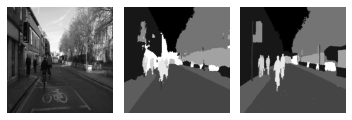

In [ ]:
img,mask=next(iter(val_dl))
_mask=model(img)
_,_mask=torch.max(_mask,dim=1)
subplots([img[0].permute(1,2,0).detach().cpu()[:,:,0],_mask.permute(1,2,0).detach().cpu()[:,:,0],mask.permute(1,2,0).detach().cpu()[:,:,0]])

In [ ]:
_mask.shape

torch.Size([1, 224, 224])



# Tiny Unet

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3),padding="same"),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def pad(in_channels, out_channels,kernel_size,stride):
  pad=(2*out_channels-in_channels-kernel_size)*(1//stride)
  return (pad,pad,pad,pad)

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def dilate_conv(in_channels, out_channels,dilation):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding="same",dilation=dilation),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class tinyUNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.block1=conv(3,64)
        self.block2=conv(64,64)
        self.block3=conv(64,128)
        self.block4=conv(128,128)
        self.block5=conv(128,256)
        self.block6=conv(256,256)
        self.block7=conv(256,512)
        self.block8=conv(512,512)
        self.block9=conv(512,1024)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256+256,256)
        self.up_conv8 = up_conv(128+128, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 +64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)
        
        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x = self.conv11(x1)

        return x

In [ ]:
model=tinyUNet().to("cuda")

In [ ]:
from torchsummary import summary

In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, ce_masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.169	trn_acc: 0.664	val_loss: 0.997	val_acc: 0.689	(60.73s - 1153.96s remaining)
EPOCH: 2.000	trn_loss: 0.832	trn_acc: 0.744	val_loss: 0.861	val_acc: 0.720	(119.88s - 1078.88s remaining)
EPOCH: 3.000	trn_loss: 0.743	trn_acc: 0.774	val_loss: 2.034	val_acc: 0.571	(178.77s - 1013.01s remaining)
EPOCH: 4.000	trn_loss: 0.687	trn_acc: 0.795	val_loss: 1.021	val_acc: 0.702	(237.63s - 950.52s remaining)
EPOCH: 5.000	trn_loss: 0.635	trn_acc: 0.813	val_loss: 0.724	val_acc: 0.793	(296.25s - 888.75s remaining)
EPOCH: 6.000	trn_loss: 0.580	trn_acc: 0.830	val_loss: 0.688	val_acc: 0.805	(354.77s - 827.79s remaining)
EPOCH: 7.000	trn_loss: 0.572	trn_acc: 0.832	val_loss: 0.620	val_acc: 0.798	(413.34s - 767.62s remaining)
EPOCH: 8.000	trn_loss: 0.546	trn_acc: 0.840	val_loss: 0.486	val_acc: 0.857	(472.42s - 708.63s remaining)
EPOCH: 9.000	trn_loss: 0.501	trn_acc: 0.853	val_loss: 0.503	val_acc: 0.849	(532.31s - 650.61s remaining)
EPOCH: 10.000	trn_loss: 0.511	trn_acc: 0.849	val_loss

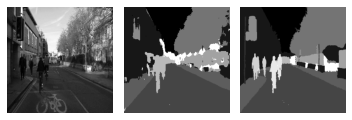

In [ ]:
img,mask=next(iter(val_dl))
_mask=model(img)
_,_mask=torch.max(_mask,dim=1)
subplots([img[0].permute(1,2,0).detach().cpu()[:,:,0],_mask.permute(1,2,0).detach().cpu()[:,:,0],mask.permute(1,2,0).detach().cpu()[:,:,0]])

In [ ]:
from torchvision.models import vgg16_bn
class tinyUNet1(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.block1=conv(3,16)
        self.block2=conv(16,16)
        self.block3=conv(16,32)
        self.block4=conv(32,32)
        self.block5=conv(32,64)
        self.block6=conv(64,64)
        self.block7=conv(64,128)
        self.block8=dilate_conv(128,128,dilation=2)
        self.block9=dilate_conv(128,256,dilation=4)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(256,128)
        self.conv6 = conv(128+128,128)
        self.up_conv7 = up_conv(128,64)
        self.conv7 = conv(64+64,64)
        self.up_conv8 = up_conv(64,32)
        self.conv8 = conv(2*32,32)
        self.up_conv9 = up_conv(32,16)
        self.conv9 = conv(2*16, 16)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(16, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)
        
        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x = self.conv11(x1)

        return x

In [ ]:
model1=tinyUNet1().to("cuda")
summary(model1,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
         MaxPool2d-7         [-1, 16, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           4,640
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,248
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             ReLU-13         [-1, 32, 112, 112]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
criterion = UnetLoss
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
n_epochs = 20

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model1, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model1, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.398	trn_acc: 0.886	val_loss: 0.589	val_acc: 0.823	(8.61s - 163.52s remaining)
EPOCH: 2.000	trn_loss: 0.373	trn_acc: 0.894	val_loss: 0.473	val_acc: 0.861	(17.13s - 154.13s remaining)
EPOCH: 3.000	trn_loss: 0.369	trn_acc: 0.894	val_loss: 0.428	val_acc: 0.872	(25.68s - 145.50s remaining)
EPOCH: 4.000	trn_loss: 0.361	trn_acc: 0.897	val_loss: 0.410	val_acc: 0.880	(34.21s - 136.86s remaining)
EPOCH: 5.000	trn_loss: 0.349	trn_acc: 0.900	val_loss: 0.392	val_acc: 0.883	(42.75s - 128.25s remaining)
EPOCH: 6.000	trn_loss: 0.346	trn_acc: 0.901	val_loss: 0.404	val_acc: 0.881	(51.29s - 119.67s remaining)
EPOCH: 7.000	trn_loss: 0.328	trn_acc: 0.906	val_loss: 0.445	val_acc: 0.873	(59.87s - 111.18s remaining)
EPOCH: 8.000	trn_loss: 0.323	trn_acc: 0.908	val_loss: 0.448	val_acc: 0.870	(68.44s - 102.66s remaining)
EPOCH: 9.000	trn_loss: 0.325	trn_acc: 0.907	val_loss: 0.459	val_acc: 0.861	(76.99s - 94.10s remaining)
EPOCH: 10.000	trn_loss: 0.318	trn_acc: 0.910	val_loss: 0.451	val_a

In [ ]:
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=val_ds.collate_fn)

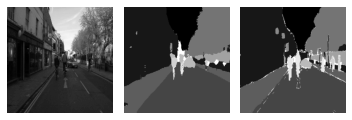

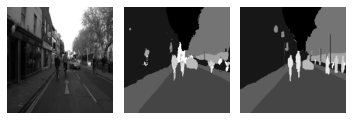

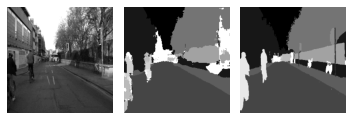

In [ ]:
img,mask=next(iter(val_dl))
_mask=model1(img)
_,_mask=torch.max(_mask,dim=1)
for i in range(4-1):
  subplots([img[i].permute(1,2,0).detach().cpu()[:,:,i],_mask.permute(1,2,0).detach().cpu()[:,:,i],mask.permute(1,2,0).detach().cpu()[:,:,i]])
